Issue: resample was creating a huge new dataframe with continuous datetime readings, leading to NaNs...
Solution: Create a new column for rounded datetimes: You can round your existing datetime column to the nearest second. This will group all data points that fall within the same second together.
Group by id and this new rounded datetime column: Then, you can apply your aggregation functions.

In [1]:
import pandas as pd
import numpy as np

df_raw = pd.read_csv("merged_data.csv")
df_raw['datetime'] = pd.to_datetime(df_raw['datetime'])
df_raw.info

/tmp/ipykernel_3802046/879962577.py:4: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv("merged_data.csv")


<bound method DataFrame.info of              X     Y     Z       EDA     HR   TEMP  id  \
0        -13.0 -61.0   5.0  6.769995  99.43  31.17  15   
1        -20.0 -69.0  -3.0  6.769995  99.43  31.17  15   
2        -31.0 -78.0 -15.0  6.769995  99.43  31.17  15   
3        -47.0 -65.0 -38.0  6.769995  99.43  31.17  15   
4        -67.0 -57.0 -53.0  6.769995  99.43  31.17  15   
...        ...   ...   ...       ...    ...    ...  ..   
11509046 -16.0 -56.0  24.0  3.386070  88.37  33.77  F5   
11509047  -8.0 -50.0  27.0  3.386070  88.37  33.77  F5   
11509048 -28.0 -36.0  28.0  3.386070  88.37  33.77  F5   
11509049 -29.0 -29.0  30.0  3.386070  88.37  33.77  F5   
11509050 -22.0 -24.0  29.0  3.374543  88.33  33.75  F5   

                              datetime  label  
0        2020-07-08 14:03:00.000000000    2.0  
1        2020-07-08 14:03:00.031249920    2.0  
2        2020-07-08 14:03:00.062500096    2.0  
3        2020-07-08 14:03:00.093750016    2.0  
4        2020-07-08 14:03:00.12

In [2]:
## The df is too large and contains unecessary info. I will drop EDA as it's not needed
df_cleanup = df_raw.drop(["EDA"], axis = 1)

## I will also get the overall acceleration from XYZ
df_cleanup["Acc"] = np.sqrt(df_cleanup["X"]**2 + df_cleanup["Y"]**2 + df_cleanup["Z"]**2)
df_cleanup.drop(["X","Y","Z"],axis=1, inplace=True)
df_cleanup.head()


,HR,TEMP,id,datetime,label,Acc
0,99.43,31.17,15,2020-07-08 14:03:00.000000000,2.0,62.569961
1,99.43,31.17,15,2020-07-08 14:03:00.031249920,2.0,71.902712
2,99.43,31.17,15,2020-07-08 14:03:00.062500096,2.0,85.264295
3,99.43,31.17,15,2020-07-08 14:03:00.093750016,2.0,88.758098
4,99.43,31.17,15,2020-07-08 14:03:00.124999936,2.0,102.698588


In [3]:
## I also want to resample the data so time step size is 1 second
df_cleanup["rounded_datetime"] = df_cleanup['datetime'].dt.round('1s')
df = df_cleanup.groupby(["id","rounded_datetime"]).agg({'Acc' : 'mean', "HR": "max", "TEMP" : "max", "label": "max"})
df = df.reset_index()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356566 entries, 0 to 356565
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   id                356566 non-null  object        
 1   rounded_datetime  356566 non-null  datetime64[ns]
 2   Acc               356566 non-null  float64       
 3   HR                356566 non-null  float64       
 4   TEMP              356566 non-null  float64       
 5   label             356566 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 16.3+ MB


In [4]:
## To make more manageable, I'll drop id and rounded_datetime
df.drop(["id","rounded_datetime"], axis=1, inplace=True)
df.head()

,Acc,HR,TEMP,label
0,62.209552,77.27,32.65,2.0
1,64.895410,77.27,32.65,2.0
2,65.631888,77.10,32.65,2.0
3,70.380108,76.93,32.65,2.0
4,67.042693,76.77,32.68,2.0


In [5]:
## Lastly, I'll check for nulls:
df.isnull().sum()

Acc      0
HR       0
TEMP     0
label    0
dtype: int64

In [6]:
## Now I will split the data into test and train sets:
import sklearn
df_train, df_test = sklearn.model_selection.train_test_split(df, test_size=.2, train_size=.8)

## I will also scale the data
scaler = sklearn.preprocessing.MinMaxScaler((0,1), copy = False)
allNormalizedTrainingData = pd.DataFrame(scaler.fit_transform(df_train), columns = df.columns)

Y_scaled = allNormalizedTrainingData["label"]
X_scaled_all = allNormalizedTrainingData[["Acc","HR","TEMP"]]
X_scaled_Acc = allNormalizedTrainingData["Acc"]
X_scaled_HR = allNormalizedTrainingData["HR"]
X_scaled_temp = allNormalizedTrainingData["TEMP"]
X_scaled_temp_HR = allNormalizedTrainingData[["HR","TEMP"]]

## Make sure to also scale the test data set to avoid overly optimistic estimation of performance and data leakage
allNormalizedTestData = pd.DataFrame(scaler.transform( df_test), columns = df.columns )

Y_test = allNormalizedTestData["label"]
X_test_all = allNormalizedTestData[["Acc","HR","TEMP"]]
X_test_Acc = allNormalizedTestData["Acc"]
X_test_HR = allNormalizedTestData["HR"]
X_test_temp = allNormalizedTestData["TEMP"]
X_test_temp_HR = allNormalizedTestData[["HR","TEMP"]]

In [7]:
## Now I will train a random forest regressor on each of the three features chosen

In [8]:
from sklearn.ensemble import RandomForestRegressor
rf_all_10 = RandomForestRegressor(n_estimators=10, random_state=42)
rf_all_10.fit(X_scaled_all,Y_scaled)

rf_Acc_10 = RandomForestRegressor(n_estimators=10, random_state=42)
rf_Acc_10.fit(X_scaled_Acc.to_frame(),Y_scaled)

rf_HR_10 = RandomForestRegressor(n_estimators=10, random_state=42)
rf_HR_10.fit(X_scaled_HR.to_frame(),Y_scaled)

rf_temp_10 = RandomForestRegressor(n_estimators=10, random_state=42)
rf_temp_10.fit(X_scaled_temp.to_frame(),Y_scaled)



from sklearn.metrics import root_mean_squared_error, r2_score
## Determine model predictive accuracy
predict_all_10 = rf_all_10.predict(X_test_all)
predict_Acc_10 = rf_Acc_10.predict(X_test_Acc.to_frame())
predict_HR_10 = rf_HR_10.predict(X_test_HR.to_frame())
predict_temp_10 = rf_temp_10.predict(X_test_temp.to_frame())

rmse_all_10 = root_mean_squared_error(Y_test, predict_all_10)
print(f'RMSE (all features, 10 trees): {rmse_all_10}')
r2_all_10 = r2_score(Y_test, predict_all_10)
print(f'R2 (all features, 10 trees): {r2_all_10}')

rmse_Acc_10 = root_mean_squared_error(Y_test, predict_Acc_10)
print(f'RMSE (Acceleration, 10 trees): {rmse_Acc_10}')
r2_Acc_10 = r2_score(Y_test, predict_Acc_10)
print(f'R2 (Acceleration, 10 trees): {r2_Acc_10}')

rmse_HR_10 = root_mean_squared_error(Y_test, predict_HR_10)
print(f'RME (HR, 10 trees): {rmse_HR_10}')
r2_HR_10 = r2_score(Y_test, predict_HR_10)
print(f'R2 (HR, 10 trees): {r2_HR_10}')

rmse_temp_10 = root_mean_squared_error(Y_test, predict_temp_10)
print(f'RMSE (Temperature, 10 trees): {rmse_temp_10}')
r2_temp_10 = r2_score(Y_test, predict_temp_10)
print(f'R2 (Temperature, 10 trees): {r2_temp_10}')

RMSE (all features, 10 trees): 0.3215947306252211
R2 (all features, 10 trees): 0.34126729191244687
RMSE (Acceleration, 10 trees): 0.4778847245576439
R2 (Acceleration, 10 trees): -0.45458021815415073
RME (HR, 10 trees): 0.3976249792091458
R2 (HR, 10 trees): -0.007021397140499097
RMSE (Temperature, 10 trees): 0.37304908710944096
R2 (Temperature, 10 trees): 0.11361307167310708


Lowest Error when all three features are used in conjunction! So, I'll use three features from now on.

What happens when I increase the number of trees to 50?

In [9]:
from sklearn.ensemble import RandomForestRegressor
rf_all_50 = RandomForestRegressor(n_estimators=50, random_state=42)
rf_all_50.fit(X_scaled_all,Y_scaled)

from sklearn.metrics import root_mean_squared_error, r2_score, accuracy_score

## Determine model predictive accuracy
predict_all_50 = rf_all_50.predict(X_test_all)

rmse_all_50 = root_mean_squared_error(Y_test, predict_all_50)
print(f'RMSE (all features, 50 trees): {rmse_all_50}')
r2_all_50 = r2_score(Y_test, predict_all_50)
print(f'R2 (all features, 50 trees): {r2_all_50}')

RMSE (all features, 50 trees): 0.3109056789370005
R2 (all features, 50 trees): 0.3843290114381491


I wonder if more trees might also help with reducing RMSE?

In [10]:
## 75 trees
rf_all_75 = RandomForestRegressor(n_estimators=75, random_state=42)
rf_all_75.fit(X_scaled_all,Y_scaled)
predict_all_75 = rf_all_75.predict(X_test_all)
rmse_all_75 = root_mean_squared_error(Y_test, predict_all_75)
print(f'RMSE (all features, 75 trees): {rmse_all_75}')
r2_all_75 = r2_score(Y_test, predict_all_75)
print(f'R2 (all features, 75 trees): {r2_all_75}')

RMSE (all features, 75 trees): 0.30988607572041754
R2 (all features, 75 trees): 0.38836052863427417


Seems like increasing the number of trees will not help much. I wonder around where the optimal number of trees will lie.

In [11]:
## 5 trees
rf_all_05 = RandomForestRegressor(n_estimators=5, random_state=42)
rf_all_05.fit(X_scaled_all,Y_scaled)
predict_all_05 = rf_all_05.predict(X_test_all)
rmse_all_05 = root_mean_squared_error(Y_test, predict_all_05)
print(f'RMSE (all features, 5 trees): {rmse_all_05}')
r2_all_05 = r2_score(Y_test, predict_all_05)
print(f'R2 (all features, 5 trees): {r2_all_05}')

## 20 trees
rf_all_20_trees = RandomForestRegressor(n_estimators=20, random_state=42)
rf_all_20_trees.fit(X_scaled_all,Y_scaled)
predict_all_20_trees = rf_all_20_trees.predict(X_test_all)
rmse_all_20_trees = root_mean_squared_error(Y_test, predict_all_20_trees)
print(f'RMSE (all features, 20 trees): {rmse_all_20_trees}')
r2_all_20_trees = r2_score(Y_test, predict_all_20_trees)
print(f'R2 (all features, 20 trees): {r2_all_20_trees}')

## 30 trees
rf_all_30 = RandomForestRegressor(n_estimators=30, random_state=42)
rf_all_30.fit(X_scaled_all,Y_scaled)
predict_all_30 = rf_all_30.predict(X_test_all)
rmse_all_30 = root_mean_squared_error(Y_test, predict_all_30)
print(f'RMSE (all features, 30 trees): {rmse_all_30}')
r2_all_30 = r2_score(Y_test, predict_all_30)
print(f'R2 (all features, 30 trees): {r2_all_30}')

## 40 trees
rf_all_40 = RandomForestRegressor(n_estimators=40, random_state=42)
rf_all_40.fit(X_scaled_all,Y_scaled)
predict_all_40 = rf_all_40.predict(X_test_all)
rmse_all_40 = root_mean_squared_error(Y_test, predict_all_40)
print(f'RMSE (all features, 40 trees): {rmse_all_40}')
r2_all_40 = r2_score(Y_test, predict_all_40)
print(f'R2 (all features, 40 trees): {r2_all_40}')

RMSE (all features, 5 trees): 0.3334048871046545
R2 (all features, 5 trees): 0.2919966661472697
RMSE (all features, 20 trees): 0.3147650684804942
R2 (all features, 20 trees): 0.3689490287712329
RMSE (all features, 30 trees): 0.312582315988538
R2 (all features, 30 trees): 0.37767078540205634
RMSE (all features, 40 trees): 0.31156578183218314
R2 (all features, 40 trees): 0.38171189851583753


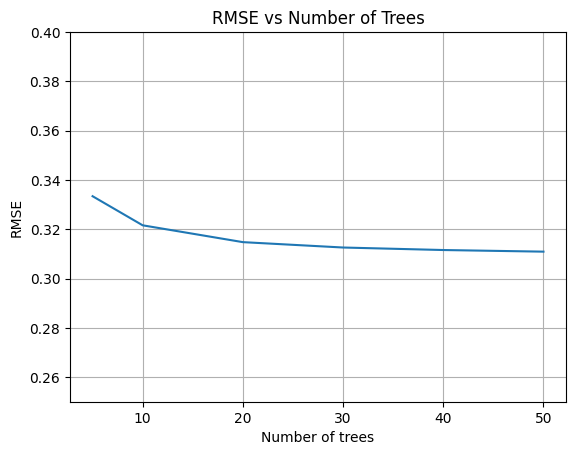

In [12]:
import matplotlib.pyplot as plt
import numpy as np

num_trees = np.array([5,10,20,30,40,50])
rms_errors = np.array([rmse_all_05, rmse_all_10, rmse_all_20_trees, rmse_all_30, rmse_all_40, rmse_all_50])

fig, ax = plt.subplots()
ax.plot(num_trees, rms_errors)

ax.set(xlabel='Number of trees', ylabel='RMSE',
       title='RMSE vs Number of Trees')
ax.set_ylim([.25,.4])
ax.grid()
plt.show()

It looks like the RMSE plateaus at around 30 trees, so I will use that to continue exploring.
There is still a lot of error, but it is interesting to see how the model performs! I will now try to use two features (no acceleration) because I know from previous experience that this can make it more difficult to analyze.

In [13]:
## Training with only TWO features, 30 trees

from sklearn.metrics import root_mean_squared_error, r2_score, accuracy_score

rf_temp_hr = RandomForestRegressor(n_estimators=30, random_state=42)
rf_temp_hr.fit(X_scaled_temp_HR,Y_scaled)
predict_temp_hr = rf_temp_hr.predict(X_test_temp_HR)
rmse_temp_hr = root_mean_squared_error(Y_test, predict_temp_hr)
print(f'RMSE (temperature and HR, 30 trees): {rmse_temp_hr}')
r2_temp_hr = r2_score(Y_test, predict_temp_hr)
print(f'R2 (temperature and HR, 30 trees): {r2_temp_hr}')

RMSE (temperature and HR, 30 trees): 0.38571222106645453
R2 (temperature and HR, 30 trees): 0.052414997252137385


Surprising! I thought Accelerometer was actually hurting the predictive model, this is really good news for my team since we want to use an accelerometer in our device. 

In [14]:
## I also want to see the k-fold cross validation to see overall performance of the best model (50 trees, all three features)
from sklearn.model_selection import cross_val_score

cv_results_r2_all = np.mean(cross_val_score(rf_all_30, X_scaled_all, Y_scaled, cv=5, scoring = 'r2')) #5-fold cross validation
cv_results_nrmse_all = np.mean(cross_val_score(rf_all_30, X_scaled_all, Y_scaled, cv=5, scoring ='neg_root_mean_squared_error'))

print(f'From 5-fold cross validation for all three features with 30 trees: \nR2={cv_results_r2_all} \nRMSE={-1*cv_results_nrmse_all}')

From 5-fold cross validation for all three features with 30 trees: 
R2=0.3741240118454458 
RMSE=0.31296627730452004


I wonder how this will work as a classifier of "low vs high" stress given the data has been scaled 0-1?

In [15]:
## Turn reggression into categorical
bins = [0,.5,1]
labels = ['Low Stress', 'High Stress']
predict_all_30_categorical = pd.cut(predict_all_30, bins=bins, labels=labels, include_lowest=True)
Y_test_categorized = pd.cut(Y_test, bins=bins, labels=labels, include_lowest=True)

sklearn.metrics.accuracy_score(Y_test_categorized, predict_all_30_categorical)

0.829220068990661

Could I optimize the cutoffs given stress falls under "1 & 2" in a scale of 0-2? Maybe if I lower the cutoff a little I can get better classification?

The max accuracy seems to be at a cutoff of .45


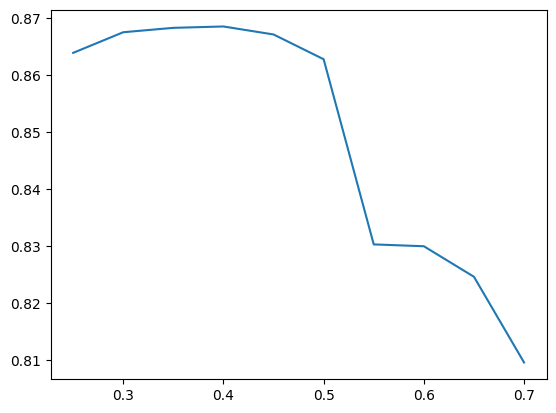

In [23]:
bin_accuracy = np.array([])
for i in np.arange(.25,.75,.05):
    bins = [0,i,1]
    predict_all_30_categorical = pd.cut(predict_all_30, bins=bins, labels=labels, include_lowest=True)
    Y_test_categorized = pd.cut(Y_test, bins=bins, labels=labels, include_lowest=True)
    this_accuracy = sklearn.metrics.accuracy_score(Y_test_categorized, predict_all_30_categorical)
    bin_accuracy = np.append(bin_accuracy, this_accuracy)

plt.plot(np.arange(.25,.75,.05), bin_accuracy)
print("The max accuracy seems to be at a cutoff of .45")

In [17]:
## Run K-fold cross validation on "classifier"
bins = [0,.45,1]
labels = ['Low Stress', 'High Stress']

from sklearn.model_selection import KFold
folds = KFold(n_splits=5, shuffle=True, random_state=42)
accuracy_array = np.array([])

for fold, (train_i, test_i) in enumerate(folds.split(X_scaled_all)):
    x_temp_train, x_temp_test = X_scaled_all.iloc[train_i], X_scaled_all.iloc[test_i]
    y_temp_train, y_temp_test = Y_scaled.iloc[train_i], Y_scaled.iloc[test_i]
    rf_all_30.fit(x_temp_train,y_temp_train)
    y_pred = rf_all_30.predict(x_temp_test)
    y_pred_cat = pd.cut(y_pred, bins=bins, labels=labels, include_lowest=True)
    y_test_cat = pd.cut(y_temp_test, bins=bins, labels=labels, include_lowest=True)
    accuracy = accuracy_score(y_test_cat, y_pred_cat)
    accuracy_array = np.append(accuracy_array, accuracy)
    
avg_accuracy = np.mean(accuracy_array)
print(f'From 5-fold cross validation for all three features with 30 trees (categorical): \nAccuracy={avg_accuracy}')

From 5-fold cross validation for all three features with 30 trees (categorical): 
Accuracy=0.8659080463255726
